# import

In [1]:
# pip install openpyxl

In [2]:
# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import chi2_contingency

# 시각화 스타일 설정
sns.set_context('notebook')  # 노트북에 최적화된 크기와 폰트

# 한글 깨짐 방지 (윈도우)
import platform
if platform.system() == 'Windows':
    matplotlib.rc('font', family='Malgun Gothic')

# 그래프에서 마이너스 기호 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False

# 경고 메시지 숨기기 (필요시)
import warnings
warnings.filterwarnings('ignore')

# file

In [ ]:
import pandas as pd

# 엑셀 파일 경로
file_path = './data/knhanes.xlsx'

# 엑셀 파일 읽기
df = pd.read_excel(file_path)

# CSV로 저장
csv_path = './data/knhanes.csv'
df.to_csv(csv_path, index=False, encoding='utf-8-sig')  # 한글 깨짐 방지

print(df.head())

c:\Users\soso2\anaconda3\envs\my_ML\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# data

### DE1_dg : 의사 진단 당뇨 유무 (0=없음·1=있음)

In [4]:
# DE1_dg 자료형과 고유값, 개수 확인
print(df['DE1_dg'].dtype)
print(df['DE1_dg'].value_counts(dropna=False))

# 데이터프레임 행 개수 확인
print("데이터 행 수:", len(df))

# 중복 행 개수 확인
print("중복 행 개수:", df.duplicated().sum())

float64
DE1_dg
0.0    5178
8.0    1022
1.0     728
NaN       1
Name: count, dtype: int64
데이터 행 수: 6929
중복 행 개수: 0


In [5]:
df_de1 = df[df['DE1_dg'].isin([1])]
diagnosed_count = df_de1['DE1_dg'].sum()
print(f"의사 진단 당뇨병 환자 수 (0,1 필터링): {diagnosed_count}")

의사 진단 당뇨병 환자 수 (0,1 필터링): 728.0


### HE_DM_HbA1c : HbA1c·공복혈당·진단 정보로 산출된 3단계 당뇨 상태 (1=정상‧2=전단계‧3=당뇨)

In [6]:
status_map = {1: '정상', 2: '당뇨병 전단계', 3: '당뇨병'}

# 결측치 아닌 데이터 개수 (상태별)
counts = df['HE_DM_HbA1c'].dropna().map(status_map).value_counts()

# 결측치 개수
missing_count = df['HE_DM_HbA1c'].isnull().sum()

print("HE_DM_HbA1c 상태별 개수:")
print(counts)
print(f"\nHE_DM_HbA1c 결측치 개수: {missing_count}")

HE_DM_HbA1c 상태별 개수:
HE_DM_HbA1c
정상         2925
당뇨병 전단계    1719
당뇨병         860
Name: count, dtype: int64

HE_DM_HbA1c 결측치 개수: 1425


### HE_glu : 공복혈당

In [7]:
def glu_status(glu):
    if pd.isna(glu):
        return None
    elif glu < 100:
        return '정상'
    elif 100 <= glu <= 125:
        return '당뇨병 전단계'
    else:
        return '당뇨병'

df['glu_status'] = df['HE_glu'].apply(glu_status)

# 상태별 개수 (결측 제외)
counts = df['glu_status'].value_counts(dropna=True)

# 결측치 개수
missing_count = df['HE_glu'].isnull().sum()

print("공복혈당 기준 당뇨 상태별 개수:")
print(counts)
print(f"\n공복혈당 결측치 개수: {missing_count}")

공복혈당 기준 당뇨 상태별 개수:
glu_status
정상         4015
당뇨병 전단계    1661
당뇨병         508
Name: count, dtype: int64

공복혈당 결측치 개수: 745


### HE_HbA1c : 당화혈색소

In [8]:
import pandas as pd

def hba1c_status(hba1c):
    if pd.isna(hba1c):
        return None
    elif hba1c < 5.7:
        return '정상'
    elif 5.7 <= hba1c <= 6.4:
        return '당뇨병 전단계'
    else:
        return '당뇨병'

df['hba1c_status'] = df['HE_HbA1c'].apply(hba1c_status)

# 상태별 개수 (결측 제외)
counts = df['hba1c_status'].value_counts(dropna=True)

# 결측치 개수
missing_count = df['HE_HbA1c'].isnull().sum()

print("당화혈색소 기준 당뇨 상태별 개수:")
print(counts)
print(f"\n당화혈색소 결측치 개수: {missing_count}")


당화혈색소 기준 당뇨 상태별 개수:
hba1c_status
정상         4232
당뇨병 전단계    1399
당뇨병         534
Name: count, dtype: int64

당화혈색소 결측치 개수: 764


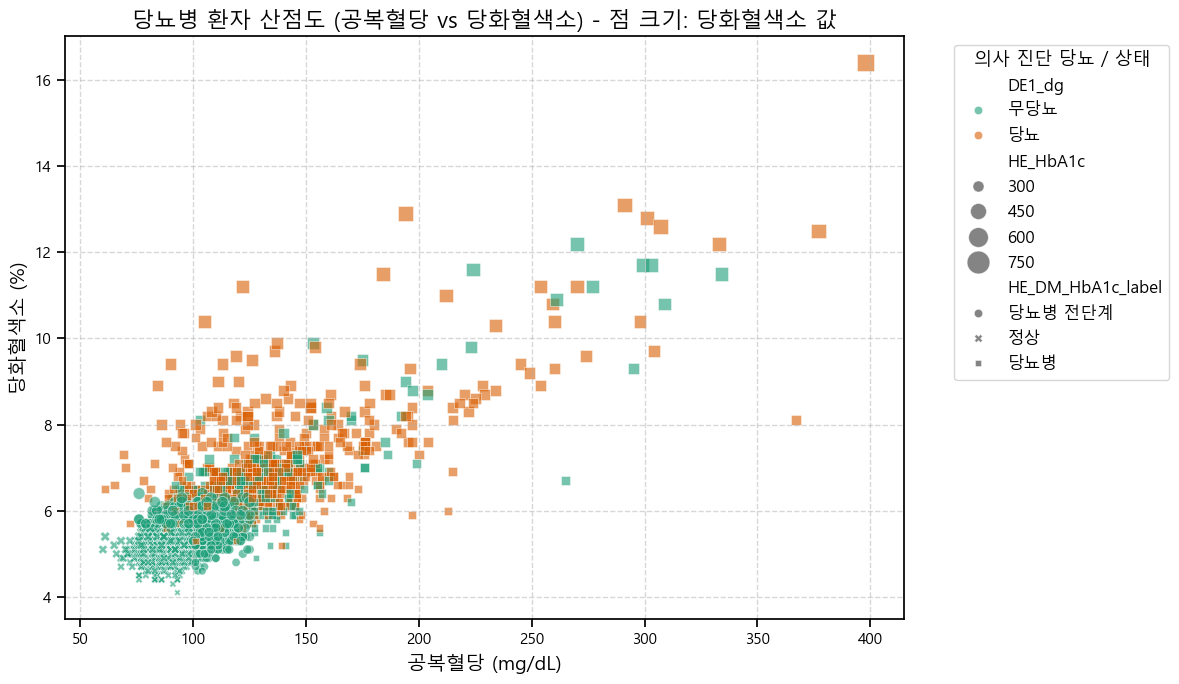

In [9]:
# 결측치 제거
df_plot = df.dropna(subset=['DE1_dg', 'HE_DM_HbA1c', 'HE_glu', 'HE_HbA1c'])

# 라벨 처리
df_plot['DE1_dg'] = df_plot['DE1_dg'].astype(int).map({0: '무당뇨', 1: '당뇨'})
status_map = {1: '정상', 2: '당뇨병 전단계', 3: '당뇨병'}
df_plot['HE_DM_HbA1c_label'] = df_plot['HE_DM_HbA1c'].map(status_map)

# 점 크기 조절 (당화혈색소 값 활용)
# 크기가 너무 크거나 작지 않게 스케일 조정
size_scale = 50
sizes = df_plot['HE_HbA1c'] * size_scale

plt.figure(figsize=(12, 7))

palette = sns.color_palette("Dark2", n_colors=2)

sns.scatterplot(
    data=df_plot,
    x='HE_glu',
    y='HE_HbA1c',
    hue='DE1_dg',
    style='HE_DM_HbA1c_label',
    palette=palette,
    size=sizes,
    sizes=(20, 300),  # 최소, 최대 점 크기 지정
    alpha=0.6
)

plt.title('당뇨병 환자 산점도 (공복혈당 vs 당화혈색소) - 점 크기: 당화혈색소 값', fontsize=16)
plt.xlabel('공복혈당 (mg/dL)', fontsize=14)
plt.ylabel('당화혈색소 (%)', fontsize=14)
plt.legend(title='의사 진단 당뇨 / 상태', fontsize=12, title_fontsize=13, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### DE1_dg & HE_DM_HbA1c 

1. DE1_dg 가 1 (의사 진단 당뇨 있음) 이고,
2. HE_DM_HbA1c 가 3 (당뇨병 상태)인 사람

In [10]:
# 두 컬럼 모두 당뇨인 사람
both_diabetes = df[(df['DE1_dg'] == 1) & (df['HE_DM_HbA1c'] == 3)]
count_both = len(both_diabetes)

# DE1_dg 당뇨인데 HE_DM_HbA1c 당뇨 아닌 사람
de1_only = df[(df['DE1_dg'] == 1) & (df['HE_DM_HbA1c'] != 3)]
count_de1_only = len(de1_only)

# HE_DM_HbA1c 당뇨인데 DE1_dg 당뇨 아닌 사람
he_only = df[(df['HE_DM_HbA1c'] == 3) & (df['DE1_dg'] != 1)]
count_he_only = len(he_only)

print(f"두 컬럼 모두 당뇨인 사람 수: {count_both}")
print(f"의사 진단 당뇨이지만 HE_DM_HbA1c 당뇨 아닌 사람 수: {count_de1_only}")
print(f"HE_DM_HbA1c 당뇨이지만 의사 진단 당뇨 아닌 사람 수: {count_he_only}")

두 컬럼 모두 당뇨인 사람 수: 666
의사 진단 당뇨이지만 HE_DM_HbA1c 당뇨 아닌 사람 수: 62
HE_DM_HbA1c 당뇨이지만 의사 진단 당뇨 아닌 사람 수: 194


결측치 갯수

In [11]:
# DE1_dg 결측치 개수
missing_de1 = df['DE1_dg'].isnull().sum()

# HE_DM_HbA1c 결측치 개수
missing_he = df['HE_DM_HbA1c'].isnull().sum()

# 둘 다 결측인 경우
missing_both = df[df['DE1_dg'].isnull() & df['HE_DM_HbA1c'].isnull()]
count_missing_both = len(missing_both)

print(f"DE1_dg 결측치 개수: {missing_de1}")
print(f"HE_DM_HbA1c 결측치 개수: {missing_he}")
print(f"두 컬럼 모두 결측인 경우 수: {count_missing_both}")

DE1_dg 결측치 개수: 1
HE_DM_HbA1c 결측치 개수: 1425
두 컬럼 모두 결측인 경우 수: 1


# Eda

## 의학적 수치 주요변수 상관관계

In [12]:
# 두 컬럼 모두 당뇨인 경우 1, 아니면 0
both_diabetes = df[(df['DE1_dg'] == 1) & (df['HE_DM_HbA1c'] == 3)]
count_both = len(both_diabetes)

In [13]:
both_diabetes # 당뇨병라벨

,mod_d,ID,ID_fam,year,region,town_t,apt_t,psu,sex,age,...,N_B1,N_B2,N_NIAC,N_FOLATE,N_VITC,LF_SECUR_Y,LF_BUYER,LF_SAFE,glu_status,hba1c_status
15,2024.12.10.,YA84384304,YA843843,2023,1,1,2,YA84,1,50,...,0.827536,1.917507,5.701646,328.650845,48.541028,1.0,1.0,2.0,당뇨병 전단계,정상
20,2024.12.10.,YA84406601,YA844066,2023,1,1,2,YA84,2,65,...,1.180931,0.743884,8.128593,92.622233,15.826529,1.0,1.0,1.0,당뇨병 전단계,당뇨병
32,2024.12.10.,YA71287202,YA712872,2023,1,1,1,YA71,2,78,...,2.627538,2.764500,19.996998,414.998280,213.880514,1.0,1.0,1.0,당뇨병,당뇨병
45,2024.12.10.,YA71329702,YA713297,2023,1,1,1,YA71,2,41,...,0.898199,1.214693,7.703150,231.460782,67.782098,1.0,1.0,2.0,당뇨병,당뇨병
68,2024.12.10.,YA90234601,YA902346,2023,1,1,2,YA90,2,68,...,1.677000,1.105305,12.923872,744.588642,190.648465,1.0,1.0,1.0,정상,당뇨병
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6909,2024.12.10.,YR62246802,YR622468,2023,8,2,1,YR62,2,71,...,0.882829,1.486338,6.916203,656.634551,121.017255,1.0,1.0,3.0,당뇨병,당뇨병
6911,2024.12.10.,YR62269001,YR622690,2023,8,2,1,YR62,2,71,...,0.487706,0.688792,4.678281,268.243055,61.646676,1.0,1.0,1.0,당뇨병 전단계,당뇨병 전단계
6922,2024.12.10.,YR62315501,YR623155,2023,8,2,1,YR62,2,62,...,0.926479,0.978752,10.464779,170.945913,218.067418,1.0,1.0,1.0,당뇨병 전단계,당뇨병 전단계
6923,2024.12.10.,YR62319601,YR623196,2023,8,2,1,YR62,2,76,...,0.311426,1.068528,3.482866,255.387704,14.592963,1.0,1.0,2.0,당뇨병,당뇨병 전단계


In [14]:
cols = [
    'HE_glu',        # 공복혈당
    'HE_HbA1c',      # 당화혈색소
    'HE_hsCRP',      # 고감도 CRP
    'HE_chol',       # 총콜레스테롤
    'HE_ht',         # 신장
    'HE_wt',         # 체중
    'HE_wc',         # 허리둘레
    'HE_BMI',        # 체질량지수
]

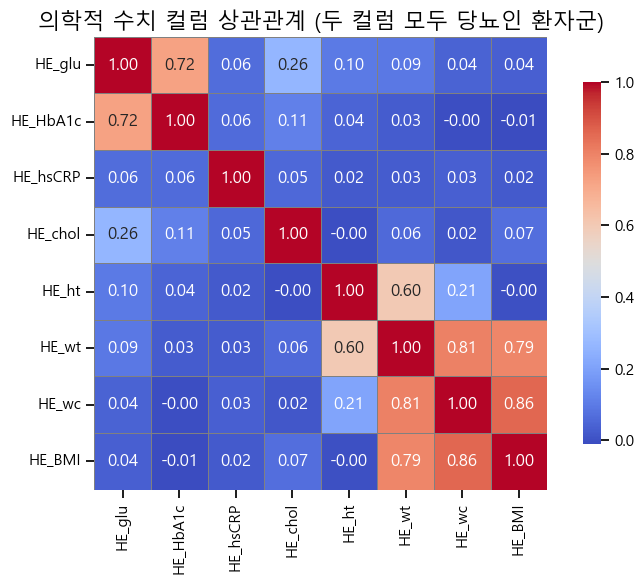

In [15]:
# 1) 대상 데이터: both_diabetes에서 필요한 컬럼만 추출
df_corr = both_diabetes[cols]

# 2) 결측치 있는 행 제거
df_corr_clean = df_corr.dropna()

# 3) 상관계수 계산
corr_matrix = df_corr_clean.corr()

# 4) 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar_kws={'shrink': 0.8},
    square=True,
    linewidths=0.5,
    linecolor='gray'
)
plt.title('의학적 수치 컬럼 상관관계 (두 컬럼 모두 당뇨인 환자군)', fontsize=16)
plt.tight_layout()
plt.show()

### 'HE_glu' 공복혈당

In [16]:
# both_diabetes에서 결측치 제거
glu_data = both_diabetes['HE_glu'].dropna()

# 기본 통계량 출력
print("공복혈당 (HE_glu) 기본 통계량:\n")
print(glu_data.describe(), "\n")
print(len(glu_data))

공복혈당 (HE_glu) 기본 통계량:

count    666.000000
mean     131.905405
std       39.681837
min       61.000000
25%      109.000000
50%      125.000000
75%      143.000000
max      398.000000
Name: HE_glu, dtype: float64 

666


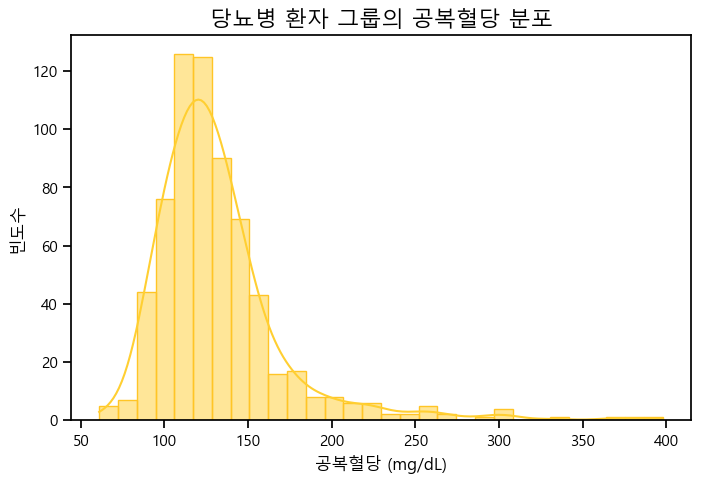

In [17]:
plt.figure(figsize=(8,5))
sns.histplot(glu_data, bins=30, kde=True, color="#ffcf32", edgecolor="#FFC526",)
plt.title('당뇨병 환자 그룹의 공복혈당 분포', fontsize=16)
plt.xlabel('공복혈당 (mg/dL)')
plt.ylabel('빈도수')
plt.show()

### 'HE_HbA1c' 당화혈색소

In [18]:
hb_data = both_diabetes['HE_HbA1c'].dropna()
print("당화혈색소 (HE_HbA1c) 기본 통계량:\n")
print(hb_data.describe(), "\n")
print(len(hb_data))

당화혈색소 (HE_HbA1c) 기본 통계량:

count    666.000000
mean       6.890390
std        1.217293
min        5.000000
25%        6.200000
50%        6.600000
75%        7.300000
max       16.400000
Name: HE_HbA1c, dtype: float64 

666


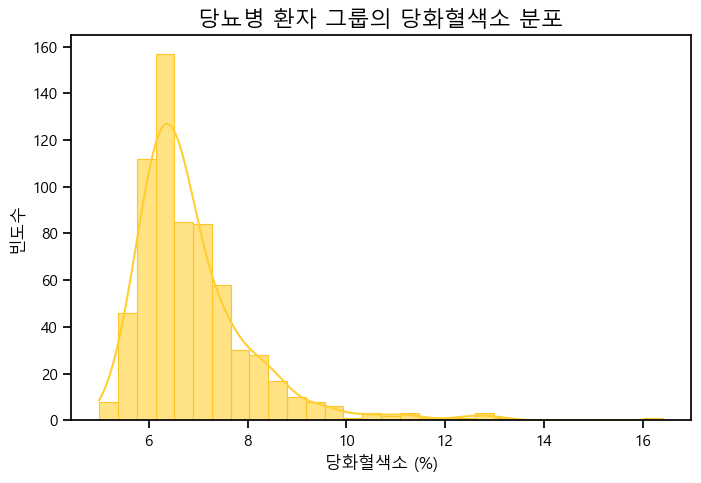

In [19]:
plt.figure(figsize=(8,5))
sns.histplot(hb_data, bins=30, kde=True, color="#ffcf32", alpha=0.6, edgecolor="#FFC526", linewidth=0.8)
plt.title('당뇨병 환자 그룹의 당화혈색소 분포', fontsize=16)
plt.xlabel('당화혈색소 (%)')
plt.ylabel('빈도수')
plt.show()

### 'HE_hsCRP' 고감도 CRP

In [20]:
hscrp_data = both_diabetes['HE_hsCRP'].dropna()
print("고감도 CRP (HE_hsCRP) 기본 통계량:\n")
print(hscrp_data.describe(), "\n")
print(len(hscrp_data))

고감도 CRP (HE_hsCRP) 기본 통계량:

count    578.000000
mean       1.765225
std        8.007045
min        0.200000
25%        0.400000
50%        0.600000
75%        1.100000
max      166.000000
Name: HE_hsCRP, dtype: float64 

578


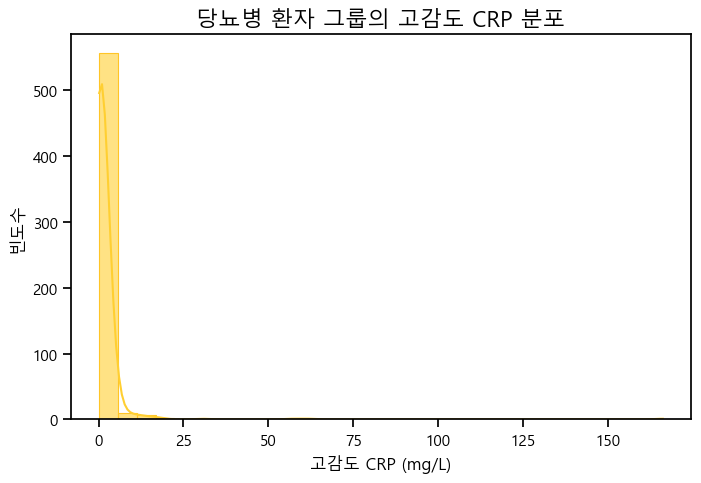

In [21]:
plt.figure(figsize=(8,5))
sns.histplot(hscrp_data, bins=30, kde=True, color="#ffcf32", alpha=0.6, edgecolor="#FFC526", linewidth=0.8)
plt.title('당뇨병 환자 그룹의 고감도 CRP 분포', fontsize=16)
plt.xlabel('고감도 CRP (mg/L)')
plt.ylabel('빈도수')
plt.show()

### 'HE_chol' 총콜레스테롤

In [22]:
chol_data = both_diabetes['HE_chol'].dropna()
print("총콜레스테롤 (HE_chol) 기본 통계량:\n")
print(chol_data.describe(), "\n")
print(len(chol_data))

총콜레스테롤 (HE_chol) 기본 통계량:

count    666.000000
mean     151.096096
std       37.451198
min       83.000000
25%      125.000000
50%      144.000000
75%      170.000000
max      421.000000
Name: HE_chol, dtype: float64 

666


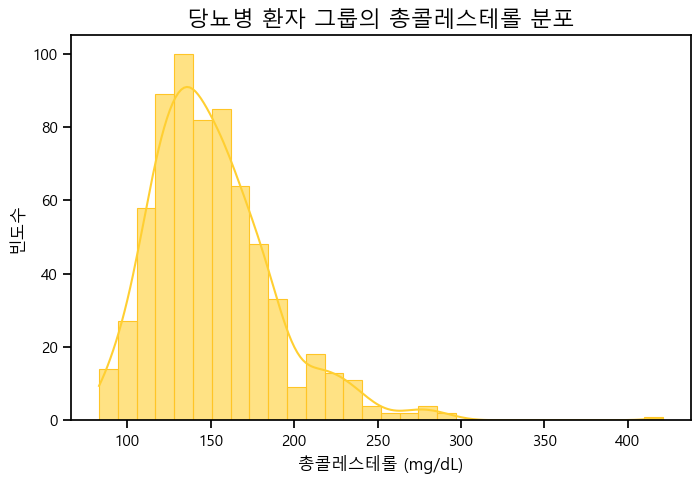

In [23]:
plt.figure(figsize=(8,5))
sns.histplot(chol_data, bins=30, kde=True, color="#ffcf32", alpha=0.6, edgecolor="#FFC526", linewidth=0.8)
plt.title('당뇨병 환자 그룹의 총콜레스테롤 분포', fontsize=16)
plt.xlabel('총콜레스테롤 (mg/dL)')
plt.ylabel('빈도수')
plt.show()

### 'HE_wc' 허리둘레

In [24]:
wc_data = both_diabetes['HE_wc'].dropna()
print("허리둘레 (HE_wc) 기본 통계량:\n")
print(wc_data.describe(), "\n")
print(len(wc_data))

허리둘레 (HE_wc) 기본 통계량:

count    644.000000
mean      89.969255
std        9.611331
min       65.600000
25%       83.775000
50%       89.700000
75%       95.525000
max      125.700000
Name: HE_wc, dtype: float64 

644


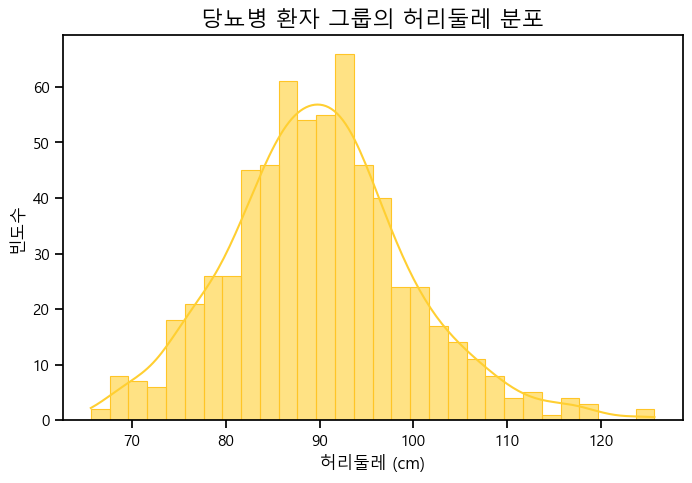

In [25]:
plt.figure(figsize=(8,5))
sns.histplot(wc_data, bins=30, kde=True, color="#ffcf32", alpha=0.6, edgecolor="#FFC526", linewidth=0.8)
plt.title('당뇨병 환자 그룹의 허리둘레 분포', fontsize=16)
plt.xlabel('허리둘레 (cm)')
plt.ylabel('빈도수')
plt.show()

### 'HE_BMI' 체질량지수

In [26]:
bmi_data = both_diabetes['HE_BMI'].dropna()
print("체질량지수 (HE_BMI) 기본 통계량:\n")
print(bmi_data.describe(), "\n")
print(len(bmi_data))

체질량지수 (HE_BMI) 기본 통계량:

count    638.000000
mean      25.171332
std        3.758415
min       16.074850
25%       22.869825
50%       24.819330
75%       27.109486
max       44.339130
Name: HE_BMI, dtype: float64 

638


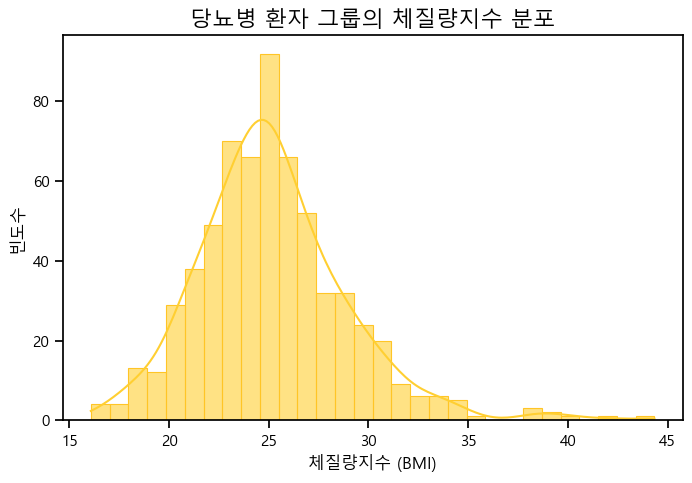

In [27]:
plt.figure(figsize=(8,5))
sns.histplot(bmi_data, bins=30, kde=True, color="#ffcf32", alpha=0.6, edgecolor="#FFC526", linewidth=0.8)
plt.title('당뇨병 환자 그룹의 체질량지수 분포', fontsize=16)
plt.xlabel('체질량지수 (BMI)')
plt.ylabel('빈도수')
plt.show()

### 'HE_sbp1' 수축기 혈압 측정 & 'HE_dbp1' 이완기 혈압 측정

In [28]:
# 3회 측정 혈압 평균 계산
df['SBP_mean'] = df[['HE_sbp1', 'HE_sbp2', 'HE_sbp3']].mean(axis=1)
df['DBP_mean'] = df[['HE_dbp1', 'HE_dbp2', 'HE_dbp3']].mean(axis=1)

def bp_category(row):
    sbp = row['SBP_mean']
    dbp = row['DBP_mean']
    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan

    # 고혈압 약물 복용 변수 있으면 추가 고려 필요 (여기선 없다고 가정)
    if sbp >= 140 or dbp >= 90:
        return '고혈압'
    elif 130 <= sbp < 140 and 80 <= dbp < 90:
        return '고혈압 전단계'
    elif 120 <= sbp < 130 and dbp < 80:
        return '주의혈압'
    elif sbp < 120 and dbp < 80:
        return '정상'
    else:
        return '분류불명'

df['BP_stage'] = df.apply(bp_category, axis=1)

# 결과 분포 확인
print(df['BP_stage'].value_counts(dropna=False))

BP_stage
정상         3625
분류불명        994
주의혈압        884
고혈압         770
NaN         335
고혈압 전단계     321
Name: count, dtype: int64


BP_stage와 당뇨병 진단 교차표:
 DE1_dg_label   당뇨   비당뇨
BP_stage               
고혈압           111   656
고혈압 전단계        39   277
분류불명          148   827
정상            258  2677
주의혈압          162   652

카이제곱 검정 결과: chi2=87.551, p-value=0.0000


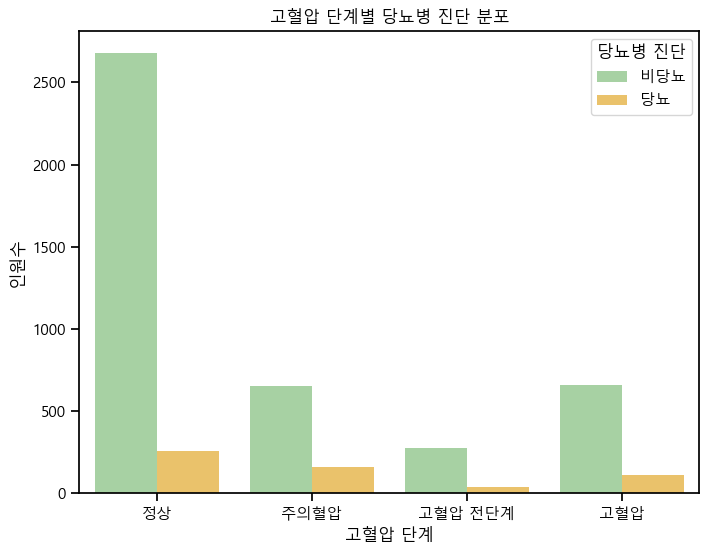

In [29]:
# 결측치 제거 (필요 컬럼 기준)
df_analysis = df.dropna(subset=['BP_stage', 'DE1_dg'])

# DE1_dg 이진 라벨 맵핑
df_analysis['DE1_dg_label'] = df_analysis['DE1_dg'].map({0:'비당뇨', 1:'당뇨'})

# 교차표 생성
contingency_table = pd.crosstab(df_analysis['BP_stage'], df_analysis['DE1_dg_label'])
print("BP_stage와 당뇨병 진단 교차표:\n", contingency_table)

# 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\n카이제곱 검정 결과: chi2={chi2:.3f}, p-value={p:.4f}")

# 시각화
plt.figure(figsize=(8,6))
sns.countplot(data=df_analysis, x='BP_stage', hue='DE1_dg_label', order=['정상','주의혈압','고혈압 전단계','고혈압'],palette=['#A1D99B', "#FFCA56"])
plt.title('고혈압 단계별 당뇨병 진단 분포')
plt.xlabel('고혈압 단계')
plt.ylabel('인원수')
plt.legend(title='당뇨병 진단')
plt.show()